# Importing Packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

# Loading Datasets

In [ ]:
train_data = pd.read_csv('/content/train_data_v2.csv')
test_data = pd.read_csv('/content/test_data_v2.csv')
validate_data = pd.read_csv('/content/validate_data_v2.csv')

train_data.info()
test_data.info()
validate_data.info()

train_data.head()
test_data.head()
validate_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 75 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Severity                                          8000 non-null   int64  
 1   Start_Time                                        8000 non-null   int64  
 2   End_Time                                          8000 non-null   int64  
 3   Distance(mi)                                      8000 non-null   float64
 4   Temperature(F)                                    8000 non-null   float64
 5   Humidity(%)                                       8000 non-null   float64
 6   Pressure(in)                                      8000 non-null   float64
 7   Visibility(mi)                                    8000 non-null   float64
 8   Wind_Speed(mph)                                   8000 non-null   float64
 9   Precipitation(in)  

,Severity,Start_Time,End_Time,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West,Weather_Day_of_Week_Friday,Weather_Day_of_Week_Monday,Weather_Day_of_Week_Saturday,Weather_Day_of_Week_Sunday,Weather_Day_of_Week_Thursday,Weather_Day_of_Week_Tuesday,Weather_Day_of_Week_Wednesday
0,2,1254,1376,0.013,46.0,83.0,29.02,10.0,0.0,0.00,...,0,0,0,1,0,0,0,0,0,0
1,2,985,1152,0.086,79.0,62.0,30.05,10.0,9.0,0.00,...,0,0,0,0,1,0,0,0,0,0
2,3,898,928,0.700,60.0,55.0,29.80,10.0,13.0,0.00,...,0,0,0,0,0,0,0,0,1,0
3,3,299,327,0.000,18.0,84.0,31.08,1.2,10.4,0.01,...,0,0,0,0,0,0,0,0,0,1
4,2,552,656,0.386,72.0,69.0,25.02,10.0,0.0,0.00,...,0,0,0,0,0,1,0,0,0,0


# Building Model

## Separate Target and Features

In [ ]:
X_train = train_data.drop(columns=['Severity'])
y_train = train_data['Severity']
X_test = test_data.drop(columns=['Severity'])
y_test = test_data['Severity']
X_validate = validate_data.drop(columns=['Severity'])
y_validate = validate_data['Severity']

## Scale Data

In [ ]:
# Scale the data before feature selection and model training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

## SVM 3rd Model (kernel = poly)

In [ ]:
svm_poly = Pipeline([
    ('svm', SVC(kernel='poly', class_weight='balanced', probability=True))
])

# Define the hyperparameter grid
param_grid = {
    'svm__C': [0.1, 1, 5],
    'svm__degree': [2, 3, 4],
    'svm__gamma': ['scale', 0.01, 0.1]
}

In [ ]:
grid_search_poly = GridSearchCV(svm_poly, param_grid, cv=5, scoring='accuracy')
grid_search_poly.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('svm',
                                        SVC(class_weight='balanced',
                                            kernel='poly',
                                            probability=True))]),
             param_grid={'svm__C': [0.1, 1, 5], 'svm__degree': [2, 3, 4],
                         'svm__gamma': ['scale', 0.01, 0.1]},
             scoring='accuracy')

In [ ]:
# Predict on validation set (for hyperparameter tuning)
best_poly_model = grid_search_poly.best_estimator_
y_validate_pred = best_poly_model.predict(X_validate_scaled)

# Evaluate performance on validation set
validate_accuracy = accuracy_score(y_validate, y_validate_pred)
validate_report = classification_report(y_validate, y_validate_pred)

# Print results on validation set
print("Best Poly SVM Model:", grid_search_poly.best_params_)
print("Validation Accuracy ", validate_accuracy)
print("Classification Report (Validation Set):\n", validate_report)

# Evaluate the best model on the test set
y_test_pred_balanced = best_poly_model.predict(X_test_scaled)
test_accuracy_balanced = accuracy_score(y_test, y_test_pred_balanced)
test_report_balanced = classification_report(y_test, y_test_pred_balanced)

# Print results
print("Test Accuracy After Balancing:", test_accuracy_balanced)
print("Classification Report:\n", test_report_balanced)

Best Poly SVM Model: {'svm__C': 1, 'svm__gamma': 0.01}
Validation Accuracy  0.418
Classification Report (Validation Set):
               precision    recall  f1-score   support

           1       0.07      0.79      0.12        14
           2       0.90      0.41      0.56       828
           3       0.23      0.48      0.32       124
           4       0.04      0.24      0.07        34

    accuracy                           0.42      1000
   macro avg       0.31      0.48      0.27      1000
weighted avg       0.77      0.42      0.51      1000

Test Accuracy After Balancing: 0.424
Classification Report:
               precision    recall  f1-score   support

           1       0.03      1.00      0.07         6
           2       0.90      0.43      0.58       857
           3       0.22      0.39      0.28       119
           4       0.03      0.39      0.06        18

    accuracy                           0.42      1000
   macro avg       0.30      0.55      0.25      1000
w

<Figure size 1000x800 with 0 Axes>

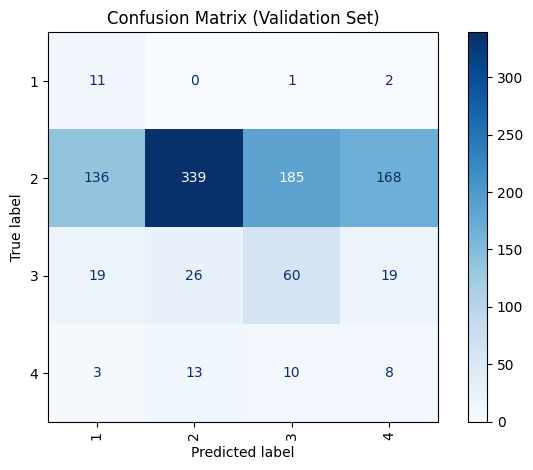

[[ 11   0   1   2]
 [136 339 185 168]
 [ 19  26  60  19]
 [  3  13  10   8]]
acc1 (Exact match accuracy): 0.4180
acc2 (One-off accuracy): 0.7940


In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(best_poly_model, X_validate_scaled, y_validate,
                                      cmap='Blues',
                                      display_labels=best_poly_model.classes_,
                                      xticks_rotation='vertical')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix

# Get the predictions
y_pred = best_poly_model.predict(X_validate_scaled)

# Get the confusion matrix
cm = confusion_matrix(y_validate, y_pred)
print(cm)

# acc1 = correct predictions / total samples
acc1 = np.trace(cm) / np.sum(cm)
print(f"acc1 (Exact match accuracy): {acc1:.4f}")

# Initialize
correct_or_one_off = 0

# Loop through the confusion matrix
n_classes = cm.shape[0]

for i in range(n_classes):
    correct_or_one_off += cm[i, i]  # exact
    if i > 0:
        correct_or_one_off += cm[i, i-1]  # one below
    if i < n_classes - 1:
        correct_or_one_off += cm[i, i+1]  # one above

# acc2 = (correct + one-off) / total samples
acc2 = correct_or_one_off / np.sum(cm)
print(f"acc2 (One-off accuracy): {acc2:.4f}")